In [1]:
# 导入SAM自动处理需要的库文件及必要函数：
import matplotlib.pyplot as plt
import cv2
from osgeo import gdal, osr
import numpy as np
import os
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
# 用来显示掩膜
def img2numpy(file_path, geoinfo=False):
    assert os.path.exists(file_path), "NO FILE!!! {}".format(file_path)
    dts = gdal.Open(file_path)
    proj = dts.GetProjection()
    geot = dts.GetGeoTransform()
    img = dts.ReadAsArray()
    if geoinfo:
        return img, proj, geot
    else:
        return img
NP2GDAL_CONVERSION = {
  "uint8": 1,
  "int8": 1,
  "uint16": 2,
  "int16": 3,
  "uint32": 4,
  "int32": 5,
  "float32": 6,
  "float64": 7,
  "complex64": 10,
  "complex128": 11,
}
def numpy2img(file_path: str, img: np.ndarray, proj=None, geot=None, type="GTiff"):
    '''
    :param file_path: Save url.
    :param img: Save numpy.ndarray image_process
    :param proj: Projection information
    :param geot: Geographic transfer information
    :return: None
    '''
    gdal_type = NP2GDAL_CONVERSION[img.dtype.name]
    if len(img.shape) == 2:
        im_height, im_width = img.shape
        img = img.reshape(1, im_height, im_width)
    im_band, im_height, im_width = img.shape

    driver = gdal.GetDriverByName(type)
    dataset = driver.Create(file_path, im_width, im_height, im_band, gdal_type)
    if dataset is not None and proj is not None:
        dataset.SetGeoTransform(geot)  # 写入仿射变换参数
        dataset.SetProjection(proj)  # 写入投影

    for i in range(im_band):
        dataset.GetRasterBand(i + 1).WriteArray(img[i, :, :])
    del dataset
def normalize_parameters(img):
    '''
    获取影像各个波段的normalize parameters
    '''
    img = np.where(img == 0, np.nan, img)
    top = np.nanpercentile(img, 99, axis=(0,1))
    bottom = np.nanpercentile(img, 1, axis=(0,1))
    return top, bottom

def normalize_apply(img, paras):
    para_top, para_bottom = paras
    for i in range(len(para_top)):
        img_bnd = img[:, :, i]
        top, bottom = para_top[i], para_bottom[i]

        img_bnd[img_bnd > top] = top
        img_bnd[img_bnd < bottom] = bottom
        img_bnd = (img_bnd - bottom) / (top - bottom) * 255
        img[:, :, i] = img_bnd
    img = img.astype("uint8")
    return img

def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.zeros((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 3))
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(2), [0.65]])
        img[m] = color_mask * 255
    return img.astype(np.uint8)
    
sam_checkpoint = r"F:\pths\sam_vit_b_01ec64.pth" # 模型
model_type = "vit_b"

In [2]:
# 数据导入
imagename = r'E:\FinalsForData\GF2\AH\Processed\Subset1rgb.tif'
image, proj, geot = img2numpy(imagename,  geoinfo=True)
image = image.transpose((1, 2, 0))[:,:,:3]
# image = cv2.normalize(image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX).astype(np.uint8)
image = normalize_apply(image, normalize_parameters(image))
# imagetest = img2numpy(r'E:\FinalsForData\GF2\AH\Processed\Subset1_DW.tif')
DW =  cv2.imread(r'E:\FinalsForData\GF2\AH\Processed\Subset1_DW.tif')[:,:,0]

# 实验测试数据处理流程
DW[DW<200] = 0
DW[DW>=200] = 1
# DW = np.ones(image.shape[:2])

# 正常数据处理流程
# DW[DW!=4] = 0
# DW[DW==4] = 1


In [3]:
# 定义梯度图及其对应的最终需要提取的地块区域的掩膜
from scipy.ndimage import sobel
# 使用 sobel() 函数计算梯度图
gradient_x = sobel(image[:,:,0]/255, axis=1)
gradient_y = sobel(image[:,:,0]/255, axis=0)
gradient = np.sqrt(gradient_x**2 + gradient_y**2)
# gradient = cv2.normalize(gradient, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
gradient[gradient >= 0.5] = 1
gradient[gradient < 0.5] = 0

# 定义膨胀和腐蚀的结构元素
kernel = np.ones((5, 5), np.uint8)  # 3x3 方形结构元素

# 膨胀操作
dilated_gradient = cv2.dilate(gradient, kernel, iterations=1)

DW[dilated_gradient == 1] = 0

In [4]:
# 定义SAM模型
device = "cuda" # 使用GPU

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU()
        )
      )
      (1): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (n

In [5]:
# 设计函数，完成在有限范围内的自动采样,均匀采样
def define_area_average_Field(mask, n_per_side):
    offset = 1 / (2 * n_per_side)
    bias = np.random.random(1) * offset
    points_one_side = np.linspace(offset, 1 - offset, n_per_side)
    points_one_side = points_one_side - bias
    points_x = np.tile(points_one_side[None, :], (n_per_side, 1))
    points_y = np.tile(points_one_side[:, None], (1, n_per_side))
    points = np.stack([points_x, points_y], axis=-1).reshape(-1, 2)
    w, h = mask.shape
    pointX = points[:,0] * w
    pointY = points[:, 1] * h
    point_image = np.array([pointX,pointY])
    point_image = point_image.transpose((1,0)).astype(np.int16)
    mask_points = [mask[coord[0],coord[1]] for coord in point_image]
    mask_points = np.array(mask_points).reshape(-1, 1)
    aa = np.zeros((n_per_side, n_per_side))
    aa[:,:n_per_side//2] = 1
    aa = aa.reshape(-1, 1)
    filtered_matrix = points * mask_points
    filtered_matrix_zeros = filtered_matrix[np.logical_not(np.all(filtered_matrix == [0, 0], axis=1))]
    filtered_matrix_zeros = np.fliplr(filtered_matrix_zeros)
    return filtered_matrix_zeros

4


F:\Soft\Conda\envs\PalSeg\lib\site-packages\segment_anything\utils\amg.py:118: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:882.)
  change_indices = diff.nonzero()


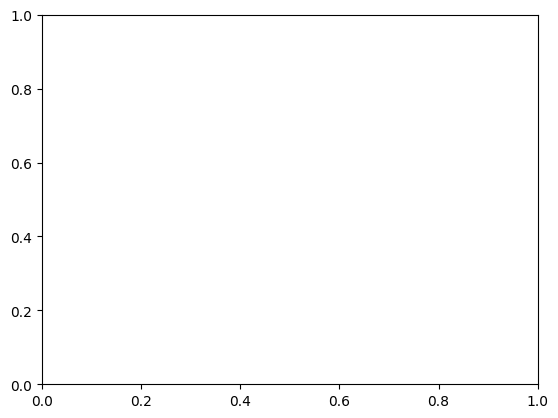

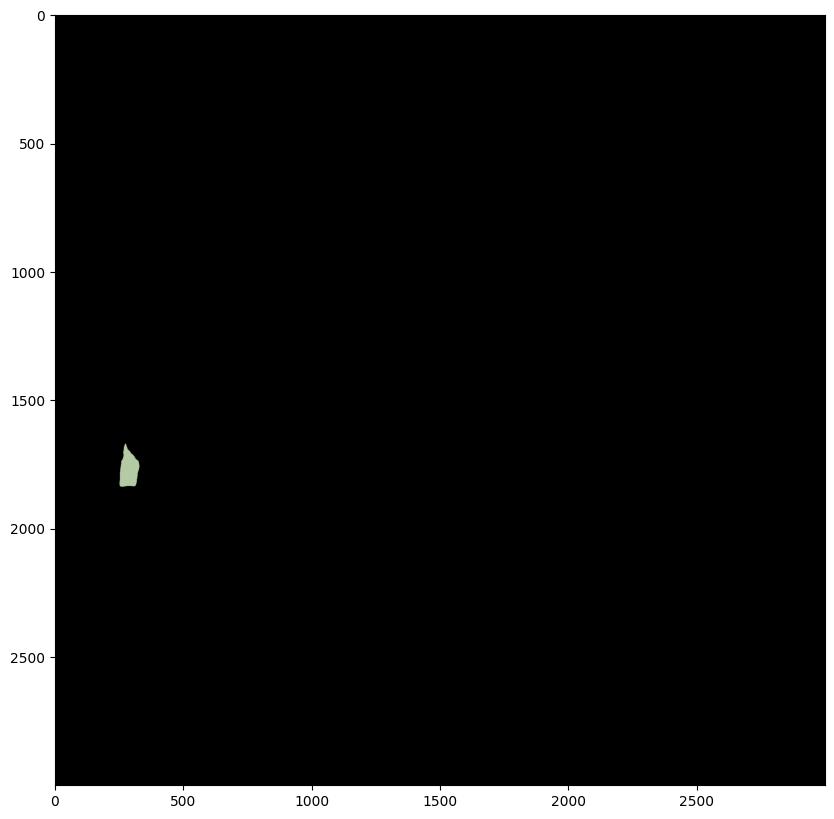

In [7]:
# 自动化田块处理过程
crop_n_points_downscale_factor = 1
stride = [4]
Total_Seed = []
for i in stride:
    print(i)
    Total_Seed.append(define_area_average_Field(DW, i))
mask_generator2 = SamAutomaticMaskGenerator(model=sam,
                                           points_per_side = None,
                                           points_per_batch = 64,
                                           pred_iou_thresh = 0.80,
                                           point_grids =Total_Seed,
                                            crop_n_layers=0,
                                            crop_n_points_downscale_factor=crop_n_points_downscale_factor,
                                            stability_score_thresh = 0.45,
                                            min_mask_region_area = 10
                                           )

masks2 = mask_generator2.generate(image)
threshold = 10000
masks2 = [item for item in masks2 if item['area'] <= threshold] # 'segmentation'
mask_sam = show_anns(masks2)
plt.figure(figsize=(10,10))
plt.imshow(mask_sam)
numpy2img(r'mask_sam.tif', mask_sam[:,:,0], proj, geot)

In [7]:
print(mask_sam.shape)

(3000, 3000, 3)
